In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as ke

In [2]:
(xtrain,ytrain),(xtest,ytest) = ke.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print(np.min(xtrain),np.max(xtrain))

0 255


In [4]:
xtrain = 2* ( (xtrain/255.0)-0.5 )

In [ ]:
print(np.min(xtrain),np.max(xtrain))

-1.0 1.0


In [5]:
xtrain.shape

(60000, 28, 28)

In [6]:
xtrain = xtrain[...,None]

In [7]:
xtrain.shape

(60000, 28, 28, 1)

In [8]:
ls_dim = 100

In [9]:
#constuir el generador
capa_entrada = ke.layers.Input(shape=(ls_dim))
capa_oculta = ke.layers.Dense(128*(28/4)*(28/4),activation="relu")(capa_entrada)
capa_oculta = ke.layers.Reshape( ( 28//4, 28//4, 128 ) )(capa_oculta)
capa_oculta = ke.layers.UpSampling2D( (2,2) )(capa_oculta) #(28/2),(28/2)
capa_oculta = ke.layers.Conv2D(64, (4,4), padding="same",activation="relu")(capa_oculta)
capa_oculta = ke.layers.UpSampling2D( (2,2) )(capa_oculta) #(28),(28)
capa_salida = ke.layers.Conv2D(1,(4,4),padding="same",activation="tanh")(capa_oculta)
generador = ke.Model(inputs=capa_entrada,outputs=capa_salida,name="Generador")
generador.summary()

Model: "Generador"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        131136    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 1)         10

In [10]:
#construir el discriminador
capa_entrada = ke.Input( (28,28,1) )
capa_oculta = ke.layers.Conv2D(64,(4,4),(2,2),padding="same",activation="relu")(capa_entrada)
capa_oculta = ke.layers.Dropout(0.25)(capa_oculta)
capa_oculta = ke.layers.Conv2D(128,(4,4),(2,2),padding="same",activation="relu")(capa_oculta)
capa_oculta = ke.layers.Dropout(0.25)(capa_oculta)
capa_oculta = ke.layers.Flatten()(capa_oculta)
capa_oculta = ke.layers.Dense(10,activation="relu")(capa_oculta)
capa_oculta = ke.layers.Dropout(0.1)(capa_oculta)
capa_salida = ke.layers.Dense(1,activation="sigmoid")(capa_oculta)
discriminador = ke.Model(inputs = capa_entrada , outputs = capa_salida,name="Discriminador")
discriminador.summary()

Model: "Discriminador"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1088      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)              

In [11]:
discriminador.compile(loss="binary_crossentropy",optimizer=ke.optimizers.Adam(0.00025,0.5))

In [12]:
capa_entrada = ke.layers.Input( (ls_dim,) )
capa_oculta = generador(capa_entrada)
capa_salida = discriminador(capa_oculta)

GAN = ke.Model(inputs = capa_entrada, outputs = capa_salida)

GAN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
Generador (Functional)       (None, 28, 28, 1)         765633    
_________________________________________________________________
Discriminador (Functional)   (None, 1)                 195029    
Total params: 960,662
Trainable params: 960,662
Non-trainable params: 0
_________________________________________________________________


In [13]:
# OLVIDÉ CONFIGURAR EL MODELO DISCRIMINADOR COMO NO ENTRENABLE
# ANTES DE LA COMPILACIÓN DEL GAN. SIN ESTO NO ES POSIBLE DESACTIVAR
# EFECTIVAMENTE EL ENTRENAMIENTO DEL DISCRIMINADOR DURANTE 
# LA ETAPA DE ENTRENAMIENTO DEL GAN.
discriminador.trainable = False

In [14]:
GAN.compile(loss="binary_crossentropy",optimizer=ke.optimizers.Adam(0.00025,0.5))

In [15]:
def GenerarRuido(n, ls_dim):
  return np.random.normal(size=[n,ls_dim])

In [16]:
def GenerarMuestra(n):
  idx = np.random.randint(0, len(xtrain), n)
  return xtrain[idx]

In [18]:
tamanio_batch = 128
nbatches = len(xtrain) // tamanio_batch
for epoch in range(15):
  for batch in range(nbatches):
    
    ruido = GenerarRuido(tamanio_batch,ls_dim)
    imagenes_generadas = generador.predict(ruido)
    
    imagenes_reales = GenerarMuestra(tamanio_batch)
    
    xdata_train = np.concatenate([imagenes_reales, imagenes_generadas])
    
    ydata_train = np.zeros(tamanio_batch*2)
    ydata_train[:tamanio_batch] = 1

    discriminador.trainable = True
    discriminador.train_on_batch(xdata_train,ydata_train)

    ruido = GenerarRuido(tamanio_batch,ls_dim)
    ydata_train = np.ones(tamanio_batch)

    discriminador.trainable = False
    GAN.train_on_batch(ruido,ydata_train)

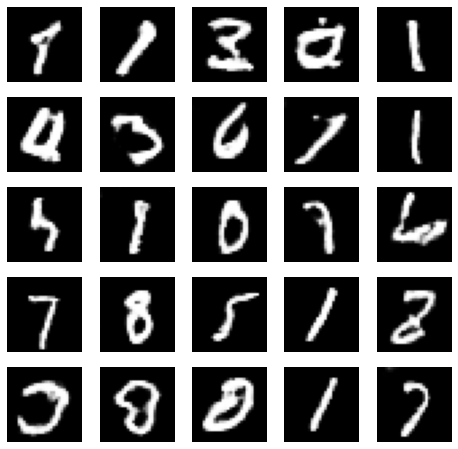

In [22]:
n = 25 #9,16,25...
ruido = GenerarRuido(n,ls_dim)
imagenes_generadas = generador.predict(ruido)

plt.figure(figsize=(8,8))
for i in range(n):
  plt.subplot(pow(n,0.5), pow(n,0.5), i+1)
  plt.imshow(imagenes_generadas[i,...,0],cmap="gray")
  plt.axis("off")